In [1]:
import plot
from scipy.special import expit
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from copy import deepcopy
import shap
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
%matplotlib inline

This is based on scikit-learn example [Logistic function](https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic.html#sphx-glr-auto-examples-linear-model-plot-logistic-py)

In [2]:
try:
    with open('dataset.pickle', 'rb') as f:
        print('Loaded cached dataset')
        X, X_test, y, feature_names, n_features, n_samples = pickle.load(f)
except FileNotFoundError:
    print('No cached dataset found')

No cached dataset found


In [3]:
try:
    with open('classifiers.pickle', 'rb') as f:
        clf_a, clf_b = pickle.load(f)
        print('Loaded cached models')
except FileNotFoundError:
    print('No cached models found')

No cached models found


In [4]:
try:
    with open('predictions.pickle', 'rb') as f:
        X_clean, feature_names, n_features, n_samples_clean, indices, pred_a, pred_b, proba_a, proba_b, log_proba_a, log_proba_b, log_odds_a, log_odds_b = pickle.load(f)
        print('Loaded cached predictions')
except FileNotFoundError:
    print('No cached predictions found')

No cached predictions found


## Generate Data

In [5]:
n_samples = 1000
n_features = 2
feature_names = ['x1', 'x2']
X, y = make_classification(n_samples=n_samples, n_features=n_features, n_redundant=0, n_informative=n_features,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.8, random_state=42)
with open('dataset.pickle', 'wb') as f:
    pickle.dump((X, X_test, y, feature_names, n_features, n_samples), f, pickle.HIGHEST_PROTOCOL)

## Train Models

In [151]:
%%time
clf_a = LogisticRegression(max_iter=10000)
clf_a.fit(X_train, y_train)
clf_b = deepcopy(clf_a)
#clf_b.intercept_ -= 1
clf_b.coef_ = np.flip(clf_a.coef_)
#clf_b.coef_[0, 1] /= 2
with open('classifiers.pickle', 'wb') as f:
    pickle.dump((clf_a, clf_b), f, pickle.HIGHEST_PROTOCOL)

CPU times: user 4.75 ms, sys: 2.75 ms, total: 7.5 ms
Wall time: 9.01 ms


## Analyze Results

## Visualize Distributions of Predictions

In [152]:
log_proba_a = clf_a.predict_log_proba(X)
log_proba_b = clf_b.predict_log_proba(X)
log_odds_a = log_proba_a[:, 1] - log_proba_a[:, 0]
log_odds_b = log_proba_b[:, 1] - log_proba_b[:, 0]

is_finite = np.isfinite(log_odds_a) & np.isfinite(log_odds_b)
X_clean = X[is_finite]
y_clean = y[is_finite]

n_samples_clean = X_clean.shape[0]
indices = np.array(range(n_samples_clean))
pred_a = clf_a.predict(X_clean)
pred_b = clf_b.predict(X_clean)
proba_a = clf_a.predict_proba(X_clean)
proba_b = clf_b.predict_proba(X_clean)
log_proba_a = clf_a.predict_log_proba(X_clean)
log_proba_b = clf_b.predict_log_proba(X_clean)
log_odds_a = log_proba_a[:, 1] - log_proba_a[:, 0]
log_odds_b = log_proba_b[:, 1] - log_proba_b[:, 0]

with open('predictions.pickle', 'wb') as f:
    pickle.dump((X_clean, feature_names, n_features, n_samples_clean, indices, pred_a, pred_b, proba_a, proba_b, log_proba_a, log_proba_b, log_odds_a, log_odds_b), f, pickle.HIGHEST_PROTOCOL)

In [153]:
np.sum(pred_a != pred_b)

381

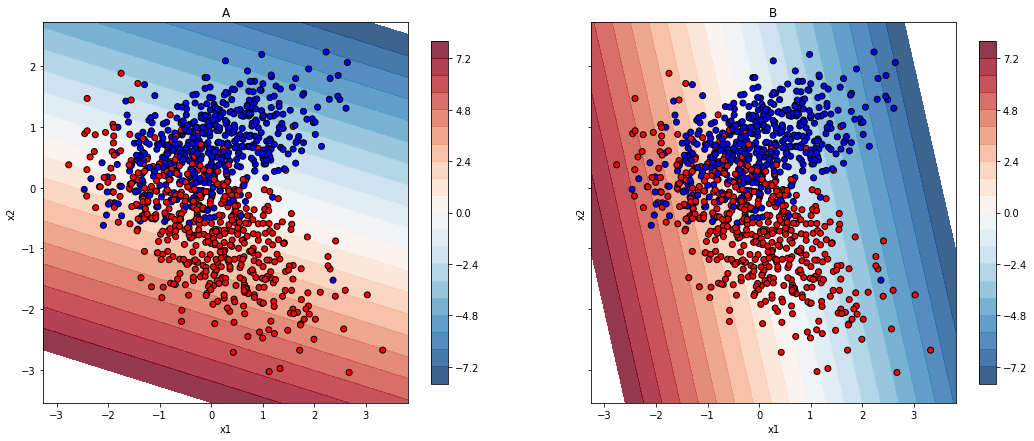

In [154]:
log_proba_to_log_odds = lambda log_proba: log_proba[:, 1] - log_proba[:, 0]
predict_log_odds_a = lambda X: log_proba_to_log_odds(clf_a.predict_log_proba(X))
predict_log_odds_b = lambda X: log_proba_to_log_odds(clf_b.predict_log_proba(X))

z_from, z_to = -8, 8
levels = np.linspace(z_from, z_to, 21)
z = y_clean
mesh_step_size = .01

x_min, x_max = X_clean[:, 0].min() - .5, X_clean[:, 0].max() + .5
y_min, y_max = X_clean[:, 1].min() - .5, X_clean[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size), np.arange(y_min, y_max, mesh_step_size))

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(2*9, 7))
for name, predict, ax in zip(('A', 'B'), (predict_log_odds_a, predict_log_odds_b), axs):
    Z = predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, levels, cmap=plt.cm.get_cmap('RdBu').reversed(), alpha=.8)
    fig.colorbar(cs, ax=ax, shrink=0.9)
    color = ['r' if _y else 'b' for _y in y]
    ax.scatter(X_clean[:, 0], X_clean[:, 1], c=color, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_title(name)

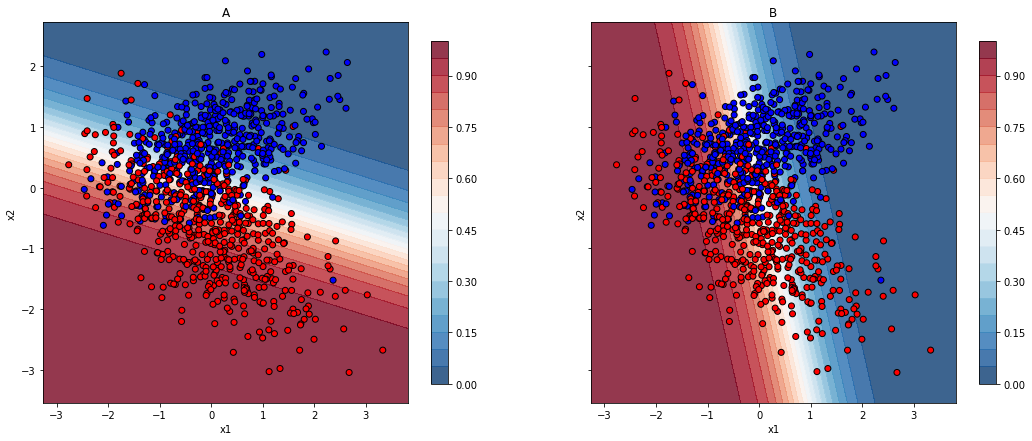

In [155]:
predict_proba_a = lambda X: clf_a.predict_proba(X)[:, 1]
predict_proba_b = lambda X: clf_b.predict_proba(X)[:, 1]

color_map = copy.copy(plt.cm.get_cmap('RdBu').reversed())
color_map_bright = copy.copy(plt.cm.get_cmap('bwr'))

z_from, z_to = 0, 1
levels = np.linspace(z_from, z_to, 21)
z = y_clean
mesh_step_size = .01

x_min, x_max = X_clean[:, 0].min() - .5, X_clean[:, 0].max() + .5
y_min, y_max = X_clean[:, 1].min() - .5, X_clean[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size), np.arange(y_min, y_max, mesh_step_size))

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(2*9, 7))
for name, predict, ax in zip(('A', 'B'), (predict_proba_a, predict_proba_b), axs):
    Z = predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, levels, cmap=color_map, alpha=.8)
    fig.colorbar(cs, ax=ax, shrink=0.9)
    ax.scatter(X_clean[:, 0], X_clean[:, 1], c=z, cmap=color_map_bright, vmin=z_from, vmax=z_to, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_title(name)

Instances with non-finite log-odds predictions:

In [156]:
pd.DataFrame(X[~is_finite]).describe()

,0,1
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


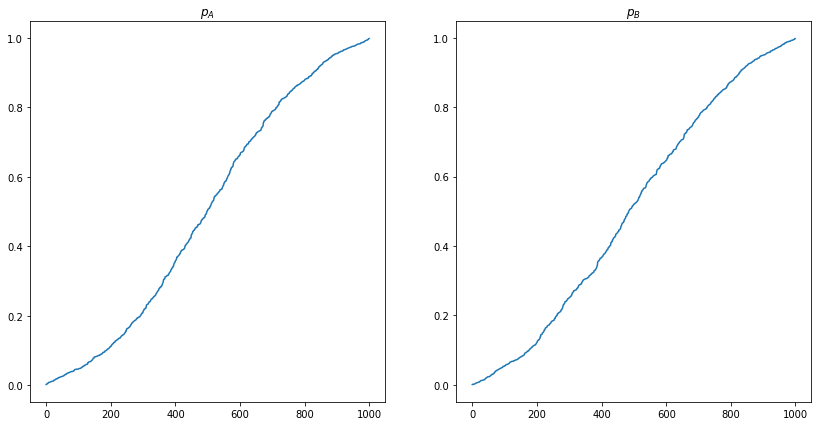

In [157]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7*2, 7))
ax1.set_title('$p_A$')
ax1.plot(sorted(proba_a[:, 1]))
ax2.set_title('$p_B$')
ax2.plot(sorted(proba_b[:, 1]));

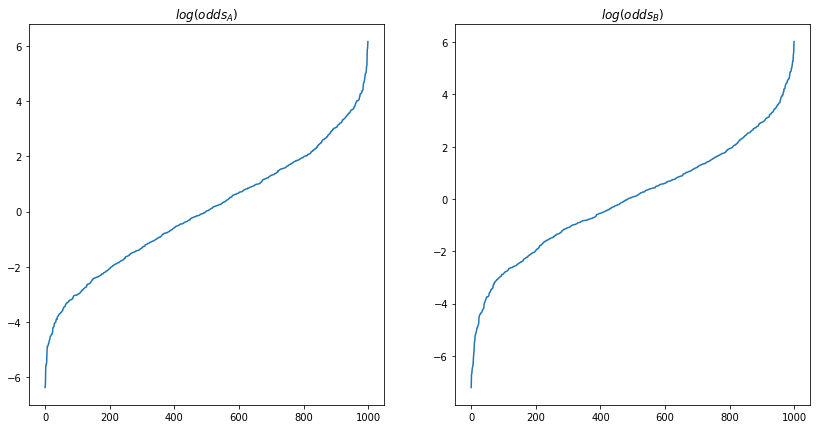

In [158]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7*2, 7))
ax1.set_title('$log(odds_A)$')
ax1.plot(sorted(log_odds_a))
ax2.set_title('$log(odds_B)$')
ax2.plot(sorted(log_odds_b));

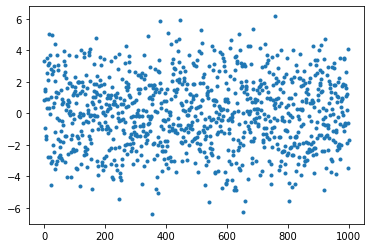

In [159]:
plt.scatter(indices, log_odds_a, marker='.');

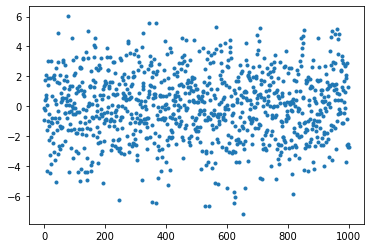

In [160]:
plt.scatter(indices, log_odds_b, marker='.');